In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from mne.filter import filter_data
from tqdm import tqdm

from config import bands, freqs
from src.metrics.phase import hilbert_decomposition
from src.util import get_dates
from util import load_session_data

#### Config

In [3]:
band_id = 0

#### Loading data

In [34]:
data = xr.load_dataarray("data/test_data.nc")

In [35]:
count = 0


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def create_generalized_surrogate(data, n_boot):
    count = 0
    trials_surr = []
    while count < n_boot:
        out = np.random.choice(
            range(data.sizes["trials"]),
            size=2,
            replace=True,
        )

        if out[0] == out[1]:
            continue
        else:
            trials_surr += [out]
            count = count + 1
    trials_surr = np.stack(trials_surr)

    count = 0
    channels_surr = []
    while count < n_boot:
        out = np.random.choice(
            range(data.sizes["roi"]),
            size=2,
            replace=True,
        )

        if out[0] == out[1]:
            continue
        else:
            channels_surr += [out]
            count = count + 1
    channels_surr = np.stack(channels_surr)

    data_surr = []
    for c_i, c_j, trial_i, trial_j in np.concatenate(
        (channels_surr, trials_surr), axis=1
    ):
        x = data[trial_i, c_i]
        y = data[trial_j, c_j][..., ::-1]
        data_surr += [np.stack((x, y))]

    data_surr = np.stack(data_surr)

    data_surr = xr.DataArray(
        data_surr, dims=("trials", "roi", "time"), coords={"time": data.time.values}
    )

    return data_surr

In [36]:
data_surr = [
    create_generalized_surrogate(data, data.sizes["trials"]) for i in tqdm(range(20))
]

100%|█████████████████████████████████| 20/20 [00:03<00:00,  6.21it/s]


In [37]:
trials_vec = np.arange(data.sizes["trials"], dtype=np.int_)

trials_vec_shuffle = np.random.permutation(trials_vec)

In [38]:
out = []
for i in range(20):
    data_surr = []
    for i in range(data.sizes["trials"]):
        indexes = np.random.choice(trials_vec, size=data.sizes["roi"], replace=False)
        temp = []
        for j in range(data.sizes["roi"]):
            temp += [data.values[indexes[j], j]]
        data_surr += [np.stack(temp)]

    out += [
        xr.DataArray(
            np.stack(data_surr, axis=0),
            dims=("trials", "roi", "time"),
            coords={"time": data.time.values},
        )
    ]
data_surr = out

In [39]:
def resample_trials(X):
    T, R, N = X.shape  # Extract dimensions
    trials = np.arange(T, dtype=np.int_)
    # Generate a shuffled set of trial indices for each row
    sampled_trials = np.array([np.random.permutation(T) for _ in range(T)])

    # Create the new array where each ROI gets data from a different trial
    resampled_X = np.zeros((T, R, N))  # Placeholder for sampled data

    for row in range(T):
        trial_indices = sampled_trials[row]  # Get shuffled trials for this row
        for roi in range(R):
            resampled_X[row, roi, :] = X[trial_indices[roi], roi, :]

    return resampled_X

In [40]:
data_surr = [
    xr.DataArray(
        resample_trials(data),
        dims=("trials", "roi", "time"),
        coords={"time": data.time.values},
    )
    for i in range(20)
]

### Filter data

In [24]:
temp = []

for f_l, f_h in bands:
    temp += [filter_data(data.values, data.fsample, f_l, f_h, n_jobs=1, verbose=False)]

temp = np.stack(temp, 2)

data = xr.DataArray(
    temp,
    dims=("trials", "roi", "freqs", "times"),
    coords={
        "trials": data.trials,
        "roi": data.roi,
        "freqs": freqs,
        "times": data.time.values,
    },
    attrs=data.attrs,
)

In [25]:
data_surr_filt = []

for data_surr_ in tqdm(data_surr):

    temp = []

    for f_l, f_h in bands:
        temp += [
            filter_data(
                data_surr_.values, data.fsample, f_l, f_h, n_jobs=1, verbose=False
            )
        ]

    temp = np.stack(temp, 2)

    data_surr_filt += [
        xr.DataArray(
            temp,
            dims=("trials", "roi", "freqs", "time"),
            coords={
                "trials": data_surr_.trials,
                "roi": data_surr_.roi,
                "freqs": freqs,
                "time": data_surr_.time.values,
            },
            attrs=data.attrs,
        )
    ]


"""
temp = []

for f_l, f_h in bands:
    temp += [filter_data(data_surr.values, data.fsample, f_l, f_h, n_jobs=1, verbose=False)]

temp = np.stack(temp, 2)

data_surr_filt = xr.DataArray(
    temp,
    dims=("trials", "roi", "freqs", "times"),
    coords={
        "trials": data_surr.trials,
        "roi": data_surr.roi,
        "freqs": freqs,
        "times": data_surr.time.values,
    },
    attrs=data.attrs,
)

""";

100%|█████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


### Compute phase differences

In [26]:
_dims = ("trials", "roi", "freqs", "times")

# for s in range(epoch_data.sizes["epochs"]):
power, phase, phase_diff = hilbert_decomposition(
    data,
    sfreq=data.fsample,
    decim=1,
    times="times",
    roi="roi",
    n_jobs=1,
    verbose=None,
)

power = power.transpose(*_dims)
phase = phase.transpose(*_dims)
phase_diff = phase_diff.transpose(*_dims)

Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise phase difference (n_pairs=1)
100%|██████████████████████████████|  : 1/1 [00:00<00:00,    3.26it/s]


In [27]:
_dims = ("trials", "roi", "freqs", "times")

phase_std_surr = []

for data_surr_ in tqdm(data_surr_filt):

    # for s in range(epoch_data.sizes["epochs"]):
    _, _, phase_diff_surr = hilbert_decomposition(
        data_surr_,
        sfreq=data.fsample,
        decim=1,
        times="time",
        roi="roi",
        n_jobs=1,
        verbose=False,
    )

    phase_diff_surr = phase_diff_surr.transpose(*_dims)

    phase_std_surr += [
        scipy.stats.circstd(phase_diff_surr, axis=(0, 1, 3)) * 180 / np.pi
    ]
"""

_dims = ("trials", "roi", "freqs", "times")

# for s in range(epoch_data.sizes["epochs"]):
_, _, phase_diff_surr = hilbert_decomposition(
    data_surr_filt,
    sfreq=data.fsample,
    decim=1,
    times="times",
    roi="roi",
    n_jobs=1,
    verbose=None,
)

phase_diff_surr = phase_diff_surr.transpose(*_dims)

""";

100%|█████████████████████████████████| 20/20 [00:31<00:00,  1.55s/it]


In [28]:
phase_std = scipy.stats.circstd(phase_diff, axis=(0, 1, 3)) * 180 / np.pi
#phase_std_surr = scipy.stats.circstd(phase_diff_surr, axis=(0, 1, 3)) * 180 / np.pi

Text(0.5, 0, 'Frequency [Hz]')

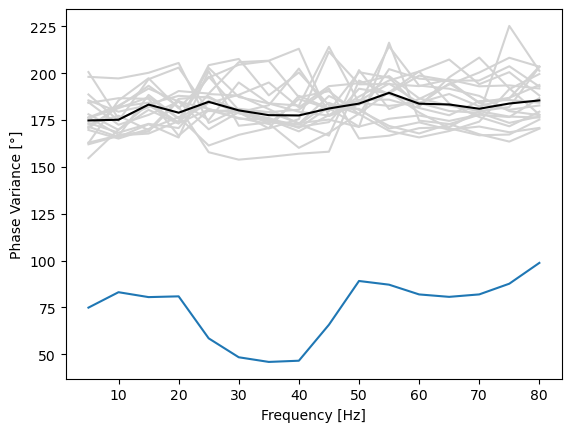

In [29]:
plt.plot(freqs, phase_std)
for i in range(20):
    plt.plot(freqs, phase_std_surr[i], c="lightgray")
plt.plot(freqs, np.median(phase_std_surr, 0), c="k")


plt.ylabel("Phase Variance [°]")
plt.xlabel("Frequency [Hz]")

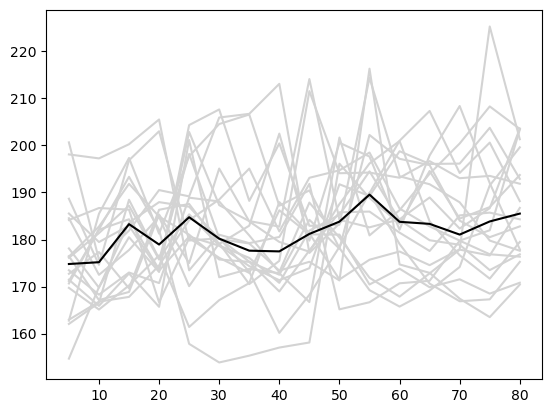

In [30]:
for i in range(20):
    plt.plot(freqs, phase_std_surr[i], c="lightgray")
plt.plot(freqs, np.median(phase_std_surr, 0), c="k")

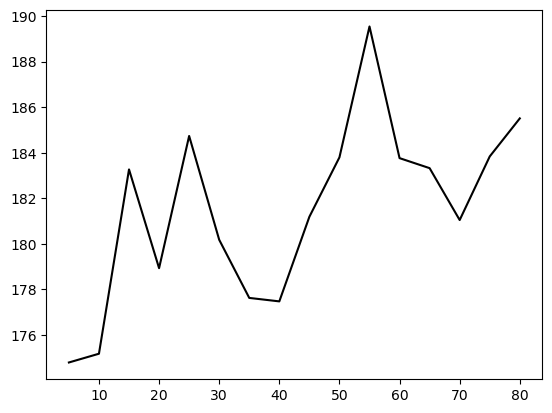

In [32]:
plt.plot(freqs, np.median(phase_std_surr, 0), c="k")

Text(0.5, 0, 'Frequency [Hz]')

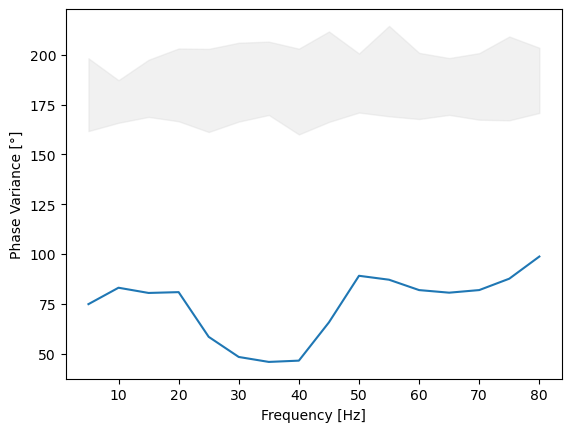

In [31]:
plt.plot(freqs, phase_std)
plt.fill_between(
    freqs,
    np.quantile(phase_std_surr, 0.05, 0),
    np.quantile(phase_std_surr, 0.95, 0),
    alpha=0.3,
    color="lightgray",
)

plt.ylabel("Phase Variance [°]")
plt.xlabel("Frequency [Hz]")